# Importação das dependências

Após a instalação do arquivo requirements, encontrado na mesma pasta que este modelo, deve-se iniciar a execução do modelo com a importação das dependÊncias que foram instaladas anteriormente.

In [2]:
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

# Definição e carregamento do modelo

Aqui realizamos a definição das principais caracteristicas do modelo utilizado e ja carregamos o mesmo para poder ser executado nos proximos passos

In [ ]:
MODEL_TYPE = "vit_b"
MODEL_PATH = #carregar o caminho do modelo SAM aqui# 


def load_sam_model(model_type=MODEL_TYPE, model_path=MODEL_PATH):
    sam = sam_model_registry[model_type](checkpoint=model_path)
    sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')

    return sam

In [16]:
sam = load_sam_model()
predictor = SamPredictor(sam)


# Filtros de processamento das imagens

Para que o modelo possa reconhecer as fissuras da melhor maneira, aqui se encontram filtros (os mesmos da pipeline de pré-processamento utilizado para o o modelo de classificação) para auxiliar nesse processo.

In [17]:
def grayscale(image: np.ndarray) -> np.ndarray:
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        return image


In [18]:
def equalize(image: np.ndarray) -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = np.ascontiguousarray(image)

    if len(image.shape) == 3:
        yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
        return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    else:
        return cv2.equalizeHist(image)

In [19]:
def clahe(image: np.ndarray, clip_limit: float = 2.0, tile_grid_size=(8, 8)) -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = np.ascontiguousarray(image)

    clahe_filter = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    if len(image.shape) == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab[:, :, 0] = clahe_filter.apply(lab[:, :, 0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        return clahe_filter.apply(image)

In [20]:
def sharpen(image: np.ndarray, strength: float = 1.0, kernel_type: str = 'laplacian') -> np.ndarray:
    image = np.asarray(image, dtype=np.uint8)

    if kernel_type == 'laplacian':
        kernel = np.array([
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
        ], dtype=np.float32)
        kernel = kernel * strength
        kernel[1, 1] = 4 * strength + 1
        kernel = np.ascontiguousarray(kernel, dtype=np.float32)
        return cv2.filter2D(image, -1, kernel)

    elif kernel_type == 'unsharp':
        gaussian = cv2.GaussianBlur(image, (0, 0), 2.0)
        return cv2.addWeighted(image, 1.0 + strength, gaussian, -strength, 0)

    else:
        raise ValueError("kernel_type deve ser 'laplacian' ou 'unsharp'")

In [21]:
class ImagePreprocessor:
    def __init__(self, dataset_dir="dataset"):
        self.dataset_dir = dataset_dir

    def process_images(self):

        for subdir in ["train", "valid"]:
            folder_path = os.path.join(self.dataset_dir, subdir)
            if os.path.exists(folder_path):
                print(f"Processing images in: {folder_path}")
                for filename in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, filename)

                    if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        print(f"Processing image: {image_path}")
                        processed_img = self.apply_filters(image_path)
                        if processed_img is not None:

                            yield processed_img, image_path
            else:
                print(f"Directory not found: {folder_path}")

    def apply_filters(self, image_path):
        try:
            img = cv2.imread(image_path)

            if img is None:
                print(f"Could not read image: {image_path}")
                return


            gray_img = grayscale(img)
            equalized_img = equalize(gray_img)
            clahe_img = clahe(equalized_img)
            sharpened_img = sharpen(clahe_img, strength=1.0, kernel_type='laplacian')

            print(f"Applied filters to {image_path}")

            return sharpened_img
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")


preprocessor = ImagePreprocessor()
preprocessor.process_images()

<generator object ImagePreprocessor.process_images at 0x000001DADA960440>

# Execução do modelo

Processing images in: dataset\train
Processing image: dataset\train\FR100_PNG.rf.effa9ab83c4c53be167e294f4eda7eda.jpg
Applied filters to dataset\train\FR100_PNG.rf.effa9ab83c4c53be167e294f4eda7eda.jpg

Detecting fissures in processed image from: dataset\train\FR100_PNG.rf.effa9ab83c4c53be167e294f4eda7eda.jpg
3 fissure(s) detected in dataset\train\FR100_PNG.rf.effa9ab83c4c53be167e294f4eda7eda.jpg


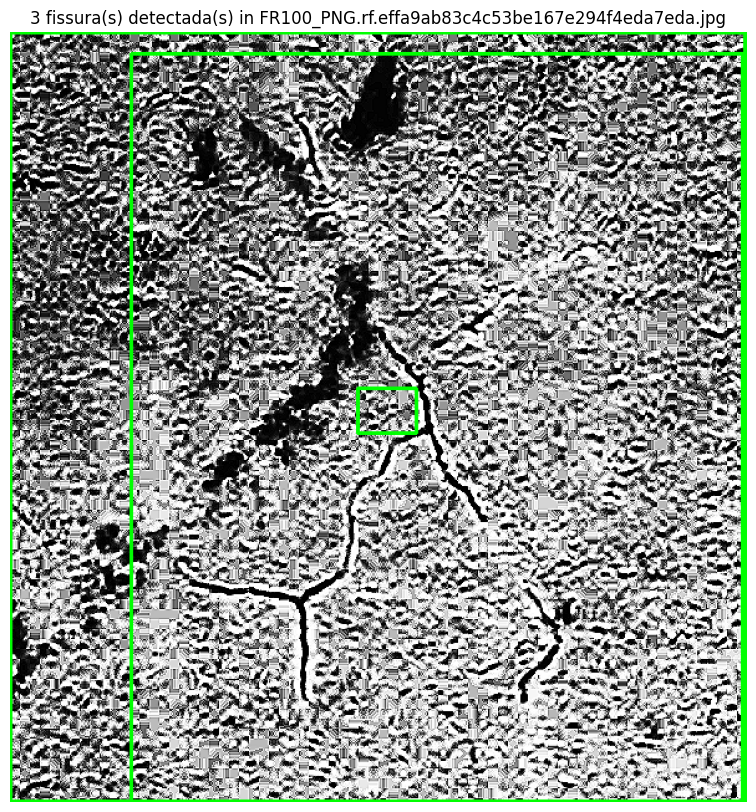

Fissura 1: Coordenadas da bounding box = (np.int64(0), np.int64(0), np.int64(590), np.int64(618)), Score = 0.93
Fissura 2: Coordenadas da bounding box = (np.int64(97), np.int64(17), np.int64(588), np.int64(618)), Score = 0.68
Fissura 3: Coordenadas da bounding box = (np.int64(279), np.int64(286), np.int64(326), np.int64(322)), Score = 0.30
Processing image: dataset\train\FR102_PNG.rf.b689bd134108e42c175391c5fc82ac96.jpg
Applied filters to dataset\train\FR102_PNG.rf.b689bd134108e42c175391c5fc82ac96.jpg

Detecting fissures in processed image from: dataset\train\FR102_PNG.rf.b689bd134108e42c175391c5fc82ac96.jpg
2 fissure(s) detected in dataset\train\FR102_PNG.rf.b689bd134108e42c175391c5fc82ac96.jpg


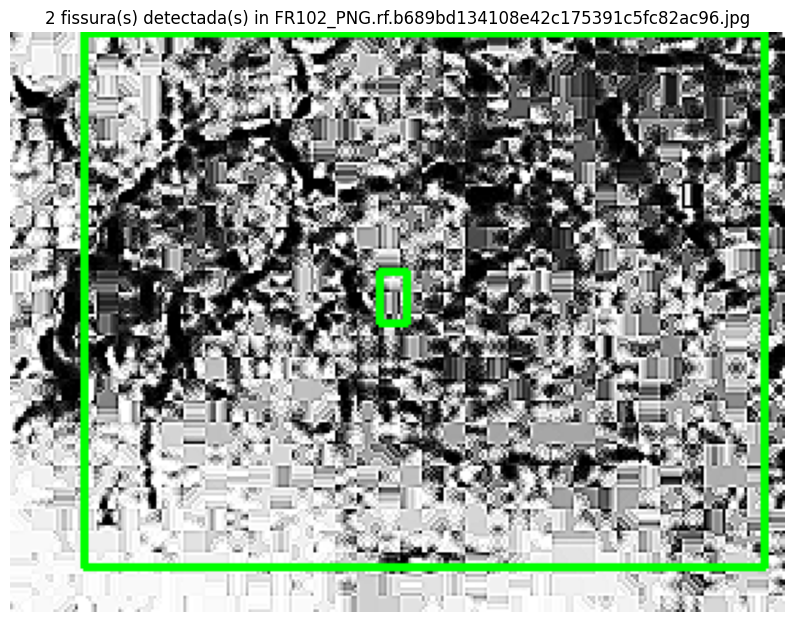

Fissura 1: Coordenadas da bounding box = (np.int64(27), np.int64(0), np.int64(278), np.int64(197)), Score = 0.48
Fissura 2: Coordenadas da bounding box = (np.int64(136), np.int64(88), np.int64(146), np.int64(107)), Score = 0.70
Processing image: dataset\train\FR104_PNG.rf.2e8cdef882a30ce3d05e264230d8564e.jpg
Applied filters to dataset\train\FR104_PNG.rf.2e8cdef882a30ce3d05e264230d8564e.jpg

Detecting fissures in processed image from: dataset\train\FR104_PNG.rf.2e8cdef882a30ce3d05e264230d8564e.jpg
3 fissure(s) detected in dataset\train\FR104_PNG.rf.2e8cdef882a30ce3d05e264230d8564e.jpg


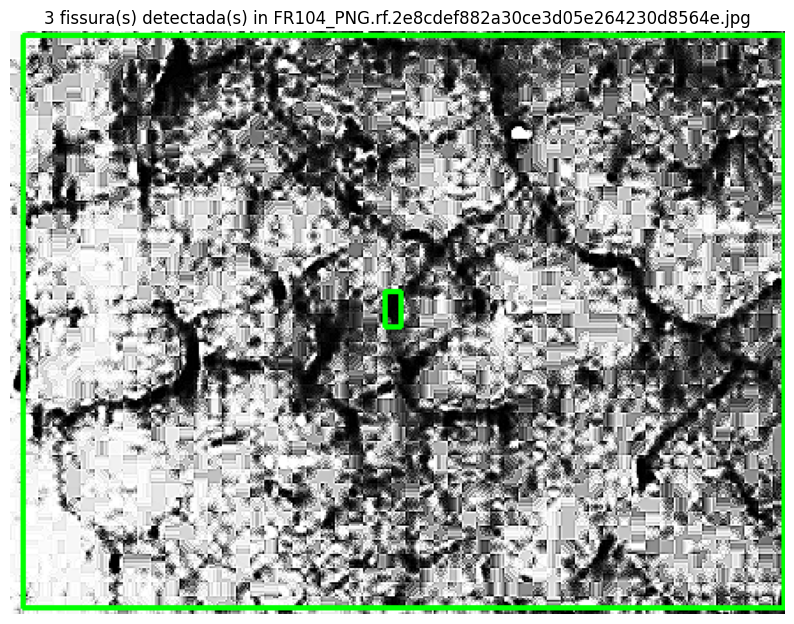

Fissura 1: Coordenadas da bounding box = (np.int64(7), np.int64(2), np.int64(438), np.int64(326)), Score = 0.47
Fissura 2: Coordenadas da bounding box = (np.int64(212), np.int64(147), np.int64(221), np.int64(167)), Score = 0.92
Fissura 3: Coordenadas da bounding box = (np.int64(212), np.int64(147), np.int64(221), np.int64(167)), Score = 0.94
Processing image: dataset\train\FR108_PNG.rf.642faa35002fb21e330a5f63629f3998.jpg
Applied filters to dataset\train\FR108_PNG.rf.642faa35002fb21e330a5f63629f3998.jpg

Detecting fissures in processed image from: dataset\train\FR108_PNG.rf.642faa35002fb21e330a5f63629f3998.jpg
2 fissure(s) detected in dataset\train\FR108_PNG.rf.642faa35002fb21e330a5f63629f3998.jpg


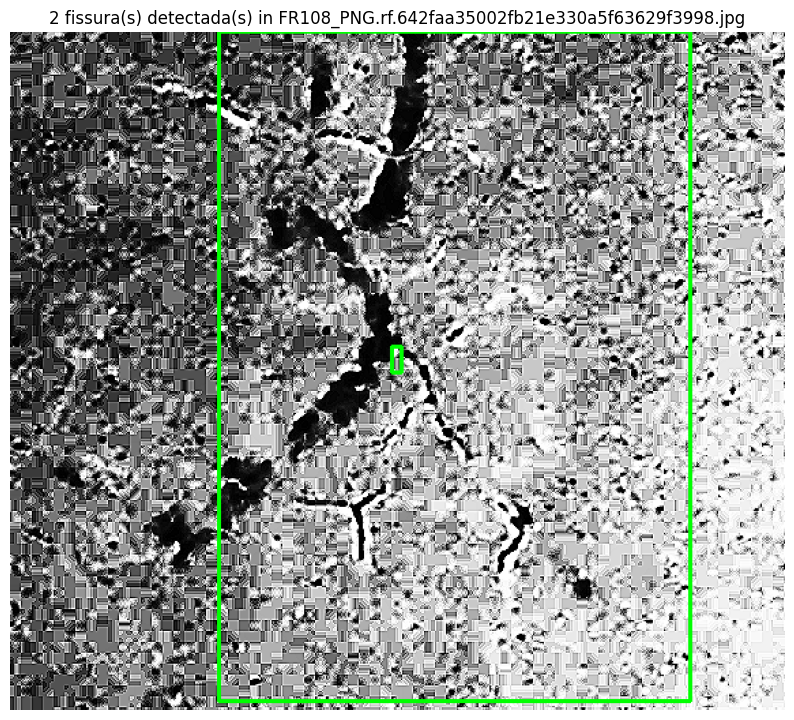

Fissura 1: Coordenadas da bounding box = (np.int64(153), np.int64(0), np.int64(499), np.int64(491)), Score = 0.38
Fissura 2: Coordenadas da bounding box = (np.int64(280), np.int64(231), np.int64(287), np.int64(250)), Score = 0.87
Processing image: dataset\train\FR10_PNG.rf.94e2fd8fe4cd88fc1cd6e2e4f42a0224.jpg
Applied filters to dataset\train\FR10_PNG.rf.94e2fd8fe4cd88fc1cd6e2e4f42a0224.jpg

Detecting fissures in processed image from: dataset\train\FR10_PNG.rf.94e2fd8fe4cd88fc1cd6e2e4f42a0224.jpg


KeyboardInterrupt: 

In [ ]:
def detectar_fissuras(image: np.ndarray, predictor: SamPredictor, threshold_area=100):
   
    if not isinstance(image, np.ndarray):
        print("Error: Input 'image' must be a NumPy array.")
        return [] 
    
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image 


    predictor.set_image(image_rgb) 


    center_x = image_rgb.shape[1] // 2
    center_y = image_rgb.shape[0] // 2
    input_point = np.array([[center_x, center_y]])
    input_label = np.array([1])

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    resultados = []
    for i, mask in enumerate(masks):
        
        y_indices, x_indices = np.where(mask)
        if len(x_indices) == 0 or len(y_indices) == 0:
            continue
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()

        
        bbox_area = (x_max - x_min) * (y_max - y_min)
        
        mask_area = np.sum(mask)

        
        if mask_area > threshold_area:
             resultados.append({
                'mask_id': i,
                'bbox': (x_min, y_min, x_max, y_max),
                'score': scores[i],
                'mask': mask
            })

    return resultados


preprocessor = ImagePreprocessor()


for processed_image, original_path in preprocessor.process_images():
    if processed_image is not None: 
        print(f"\nDetecting fissures in processed image from: {original_path}")

        
        resultados = detectar_fissuras(processed_image, predictor)

        
        if resultados:
            print(f"{len(resultados)} fissure(s) detected in {original_path}")

            
            image_with_bboxes = processed_image.copy()

            
            if len(image_with_bboxes.shape) == 2:
                image_with_bboxes = cv2.cvtColor(image_with_bboxes, cv2.COLOR_GRAY2RGB)


            
            for r in resultados:
                x_min, y_min, x_max, y_max = r['bbox']
                
                cv2.rectangle(image_with_bboxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # Green color, thickness 2

            plt.figure(figsize=(10, 10))
            plt.imshow(image_with_bboxes) 
            plt.title(f'{len(resultados)} fissura(s) detectada(s) in {os.path.basename(original_path)}')
            plt.axis('off')
            plt.show()

            
            for i, r in enumerate(resultados):
                print(f"Fissura {i+1}: Coordenadas da bounding box = {r['bbox']}, Score = {r['score']:.2f}")
        else:
            print(f"No fissures detected in {original_path}")